# Packages

In [1]:
using Pkg; Pkg.activate("."); 
using StatsBase
using MUST
using PyPlot
using Interpolations
using PyCall
using KernelDensity
using DelimitedFiles
using Printf
using TSO

#import PyCall.rc
#rc("font", size=17)

MUST.@import_dispatch "/u/peitner/DISPATCH/dispatch2"

MUST.@get_help visual
pl = pyimport("matplotlib.pylab");

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/solar_model/Project.toml`


# Tables

In [2]:
eos_path = "input_data/solar_lte"
eos_path = "input_data/TSO_sun_Magg_v10.1"
eos_path = "input_data/LegacyStagger_sun"
eos_path = "input_data/TSO_sun_Magg_v10.2"
eos_path = "input_data/DIS_MARCS_v0.1.1"
#eos_path = "input_data/DIS_MARCS_v0.3.1"
sqEOS    = MUST.SquareGasEOS(MUST.@in_dispatch(eos_path));

The stagger model to compare with

In [3]:
folder_stagger = "/ptmp/peitner/model_grid/MUST.jl/examples/stagger2bifrost"
stagger        = MUST.Box("box_solar_stagger_MARCS", folder=folder_stagger);
stagger_t      = MUST.Box("box_solar_stagger_MARCS_t", folder=folder_stagger);

A mean model from Stein & Nordlund 1997

In [4]:
ztSN = readdlm("stein_nordlund_1997_mean_T.csv", ',')
zSN, tSN = ztSN[:, 1] .* 1e8, ztSN[:, 2] .* 1e3
modelSN  = Model1D(zSN, similar(tSN), log.(tSN), similar(tSN), 4.4);

In [5]:
#folders = [ #MUST.@in_dispatch("data/LEG_sun_test_TDZ_corr6"),
#            MUST.@in_dispatch("data/TSO_sun_v10.2_TDZ12"),
#            MUST.@in_dispatch("data/DIS_AESOPUS_v1.3.2_profile"), #TS-eos
#            MUST.@in_dispatch("data/DIS_MARCS_v0.1.1_TDZ2")]
#snaps = [78, 65, 80]


folders =  [#MUST.@in_dispatch("data/DIS_MARCS_v0.1.1_TDZ2"),
            MUST.@in_dispatch("data/DIS_MARCS_v0.1.1_TDZ3"),
#            MUST.@in_dispatch("data/DIS_MARCS_v0.3.1_TDZ3"),
            MUST.@in_dispatch("data/DIS_MARCS_v0.1.1_TDZ6"),
#            MUST.@in_dispatch("data/DIS_MARCS_v0.3.1_TDZ5")]
            #MUST.@in_dispatch("data/DIS_MARCS_v0.3.1_profile")]
            MUST.@in_dispatch("data/DIS_MARCS_v0.3.1_TDZ5")]
snaps = [74, 50, 99, 85]

folders =  [
            MUST.@in_dispatch("data/DIS_MARCS_v0.3.1_TDZ-1"),
            MUST.@in_dispatch("data/DIS_MARCS_v0.3.1_TDZ-2"),
            MUST.@in_dispatch("data/DIS_MARCS_v0.3.1_TDZ-3"),
            MUST.@in_dispatch("data/DIS_MARCS_v0.3.1_TDZ-4"),
            MUST.@in_dispatch("data/DIS_MARCS_v0.3.1_TDZ-6"),
            MUST.@in_dispatch("data/DIS_MARCS_v0.3.1_TDZ-7")
          ]
            
snaps = [40, 18, 40, 40, 40, 28]


folders = [MUST.@in_dispatch("data/DISSTAG_v0.1_profile")]
snaps   = [65]

folders = [ MUST.@in_dispatch("data/DIS_MARCS_v0.3.1_TDZ5_testing"), 
            MUST.@in_dispatch("data/DIS_MARCS_v0.3.1_TDZ6_testing"), 
            MUST.@in_dispatch("data/DIS_MARCS_v0.3.1_TDZ7_testing")]
snaps   = [98, 98, 98]

folders = [MUST.@in_dispatch("data/DISSTAG_v0.1_TDZ3")]
snaps   = [70]
labels   = ["test"]


#folders = [ MUST.@in_dispatch("data/DIS_MARCS_v0.4.3_profile"), 
#            MUST.@in_dispatch("data/DIS_MARCS_v0.4.4_profile")]
#snaps   = [70, 65]
#labels = ["12 bins (Beeck)", "4 bins (Muram)"]

folders = [ MUST.@in_dispatch("data/DIS_MARCS_v0.4.4_TDZ2")]
snaps   = [93]
labels = ["MARCS (4 bins) - cooler adiabat"]


#folders = [ MUST.@in_dispatch("data/DIS_MARCS_v0.4.1_profile")]
#snaps   = [62]



#folders = [ #MUST.@in_dispatch("data/DIS_MARCS_v0.4.4_profile"),
#          MUST.@in_dispatch("data/DISSTAG_v0.1_profile")]
#snaps   = [65, 62]
#labels = ["Legacy Stagger"]


#folders = [MUST.@in_dispatch("data/TAB_sun_TDZ1")]
#snaps   = [123]
#labels  = ["Tabgen"]

folders = [MUST.@in_dispatch("data/DIS_MARCS_v0.4.4_profile_h3")]
snaps   = [22]
labels  = ["MARCS (hres, short)"]


model, model_t = [first(MUST.Boxes(folder1, snaps=[snaps[i]])) for (i,folder1) in enumerate(folders)], 
                 [last(MUST.Boxes(folder1, snaps=[snaps[i]])) for (i,folder1) in enumerate(folders)];

In [6]:
#labels = ["MARCS 3", "MARCS 6", "DIS-STAGGER profile"]
#labels = ["1", "2", "3", "4", "6", "7"]
#labels = ["Legacy Opacities"]

#labels = ["test1", "test2", "test3"]

color = colors_map("rainbow", length(model)) ;

# Optical depth scale

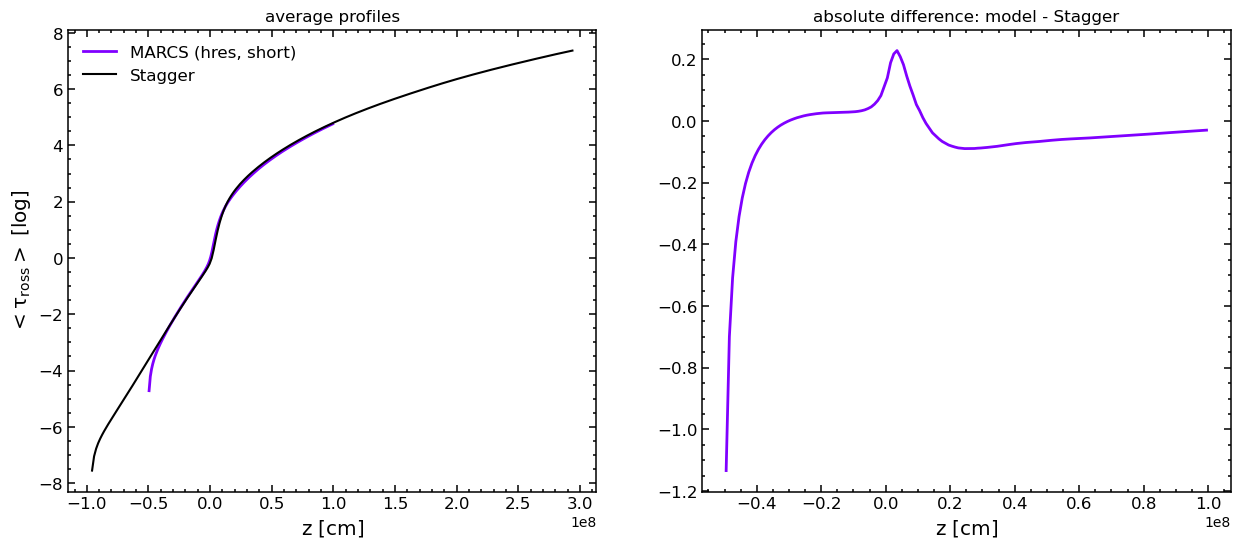

In [7]:
# Plotting
close()
f, ax = plt.subplots(1, 2, figsize=(15,6))
basic_plot!.(ax)


d_stagger  = log10.(MUST.plane_statistic(mean, stagger, :τ_ross))
z_stagger  = MUST.axis(stagger, :z)

for i in eachindex(model)
    d = log10.(MUST.plane_statistic(mean, model[i], :τ_ross))
    z = MUST.axis(model[i], :z)

    d_ip = Interpolations.linear_interpolation(z_stagger, d_stagger, extrapolation_bc = Line())(z)

    ax[1].plot(-z, d, label=labels[i], color=color[i], lw=2)
    ax[2].plot(-z, d .- d_ip, label=labels[i], color=color[i], lw=2)
end

## Stagger 
ax[1].plot(-z_stagger,  d_stagger,  color="k", label="Stagger")

## Plot style
ax[1].set_ylabel(L"\rm <\tau_{ross}>\ [log]", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")

ax[1].set_title("average profiles", fontsize="large")
ax[2].set_title("absolute difference: model - Stagger", fontsize="large")

ax[1].legend(framealpha=0, loc="upper left", fontsize="large");

#ax[1].axhline(2)
#ax[1].axvline(0.15e8)


gcf()

# Average T-z profiles

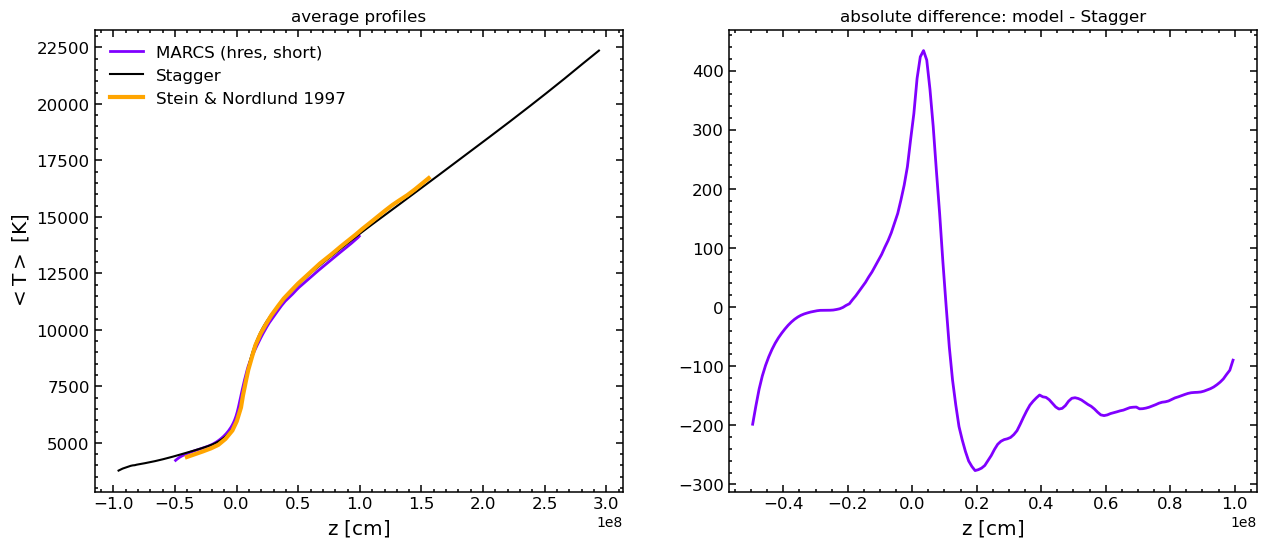

In [8]:
# Plotting
close()
f, ax = plt.subplots(1, 2, figsize=(15,6))
basic_plot!.(ax)


d_stagger  = MUST.plane_statistic(mean, stagger, :T)
z_stagger  = MUST.axis(stagger, :z)

d_SN = exp.(modelSN.lnT)
z_SN = modelSN.z

zd = zeros(length(z_stagger), 2)
zd[:, 1] .= z_stagger
zd[:, 2] .= d_stagger
writedlm("stagger_zT.txt", zd)


for i in eachindex(model)
    d = MUST.plane_statistic(mean, model[i], :T)
    z = MUST.axis(model[i], :z) #.-0.15e8

    d_ip = Interpolations.linear_interpolation(z_stagger, d_stagger, extrapolation_bc = Line())(z)

    zd = zeros(length(z), 2)
    zd[:, 1] .= z
    zd[:, 2] .= d
    writedlm("$(labels[i])_zT.txt", zd)

    ax[1].plot(-z, d, label=labels[i], color=color[i], lw=2)
    ax[2].plot(-z, d .- d_ip, label=labels[i], color=color[i], lw=2)
end

## Stagger 
ax[1].plot(-z_stagger,  d_stagger,  color="k", label="Stagger")

## Stein & Nordlund 1997
ax[1].plot(z_SN .+0.08e8,  d_SN,  color="orange", label="Stein & Nordlund 1997", lw=3)


## Plot style
ax[1].set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")

ax[1].set_title("average profiles", fontsize="large")
ax[2].set_title("absolute difference: model - Stagger", fontsize="large")

ax[1].legend(framealpha=0, loc="upper left", fontsize="large");

#ax[1].set_xlim(-0.8e8,1.5e8)
#ax[1].set_ylim(3000, 17000)

gcf()

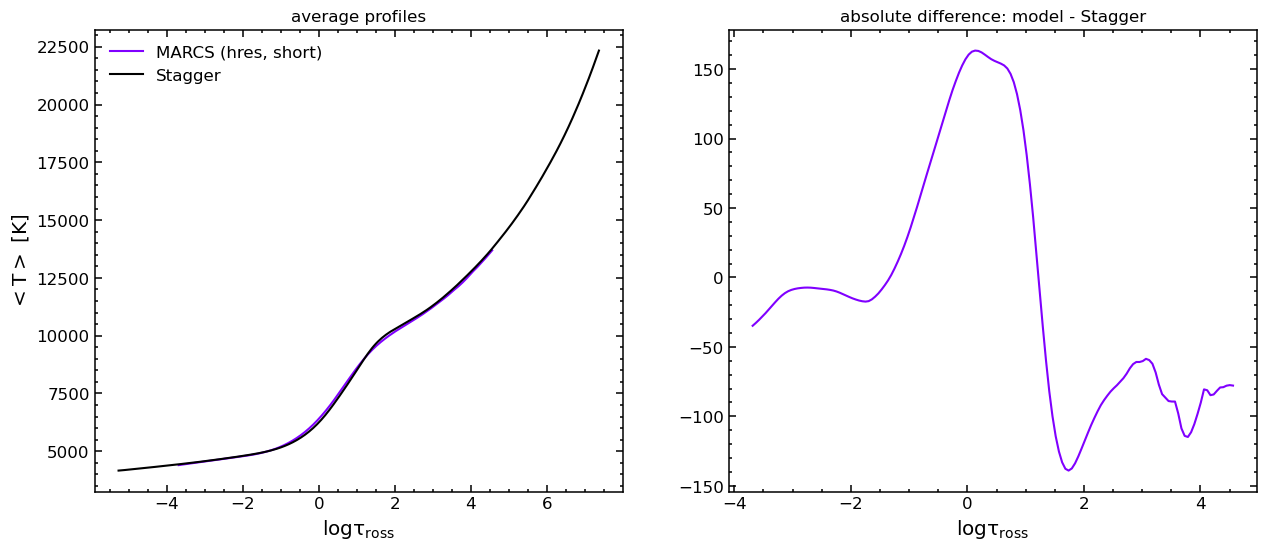

In [9]:
# Plotting
close()
f, ax = plt.subplots(1, 2, figsize=(15,6))
basic_plot!.(ax)


d_stagger  = MUST.plane_statistic(mean, stagger_t, :T)
z_stagger  = log10.(MUST.axis(stagger_t, :τ_ross, 3))

zd = zeros(length(z_stagger), 2)
zd[:, 1] .= z_stagger
zd[:, 2] .= d_stagger
writedlm("stagger_ztau.txt", zd)

for i in eachindex(model)
    d = MUST.plane_statistic(mean, model_t[i], :T)
    z = log10.(MUST.axis(model_t[i], :τ_ross, 3))

    d_ip = Interpolations.linear_interpolation(reverse(z_stagger), reverse(d_stagger), extrapolation_bc = Line())(z)

    zd = zeros(length(z), 2)
    zd[:, 1] .= z
    zd[:, 2] .= d
    writedlm("$(labels[i])_ztau.txt", zd)

    ax[1].plot(z, d, color=color[i], label=labels[i])
    ax[2].plot(z, d .- d_ip, color=color[i], label=labels[i])
end

## Stagger 
ax[1].plot(z_stagger,  d_stagger,  color="k", label="Stagger")

## Plot style
ax[1].set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")
ax[1].set_xlabel(L"\rm \log \tau_{ross}", fontsize="x-large")
ax[2].set_xlabel(L"\rm \log \tau_{ross}", fontsize="x-large")

ax[1].set_title("average profiles", fontsize="large")
ax[2].set_title("absolute difference: model - Stagger", fontsize="large")

ax[1].legend(framealpha=0, loc="upper left", fontsize="large");


#ax[1].set_xlim(-4,4)
#ax[1].set_ylim(4000,13000)

#ax[2].set_xlim(-4,4)
#ax[1].set_ylim(4000,13000)


gcf()

# Average $\rho$-z profiles

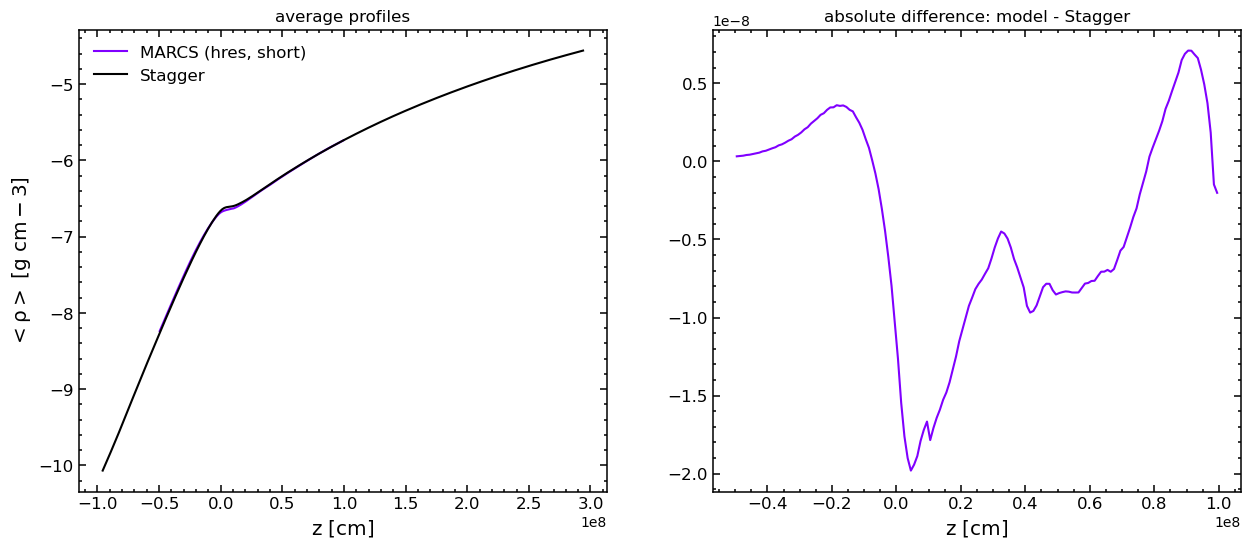

In [10]:
# Plotting
close()
f, ax = plt.subplots(1, 2, figsize=(15,6))
basic_plot!.(ax)


d_stagger  = MUST.plane_statistic(mean, stagger, :d)
z_stagger  = MUST.axis(stagger, :z)

for i in eachindex(model)
    d = MUST.plane_statistic(mean, model[i], :d)
    z = MUST.axis(model[i], :z) #.- 0.1e8

    d_ip = Interpolations.linear_interpolation(z_stagger, d_stagger, extrapolation_bc = Line())(z)

    ax[1].plot(-z, log10.(d), color=color[i], label=labels[i])
    ax[2].plot(-z, d .- d_ip, color=color[i], label=labels[i])
end

## Stagger 
ax[1].plot(-z_stagger,  log10.(d_stagger),  color="k", label="Stagger")

## Plot style
ax[1].set_ylabel(L"\rm <\rho> \ [g \ cm-3]", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")

ax[1].set_title("average profiles", fontsize="large")
ax[2].set_title("absolute difference: model - Stagger", fontsize="large")

ax[1].legend(framealpha=0, loc="upper left", fontsize="large");

gcf()

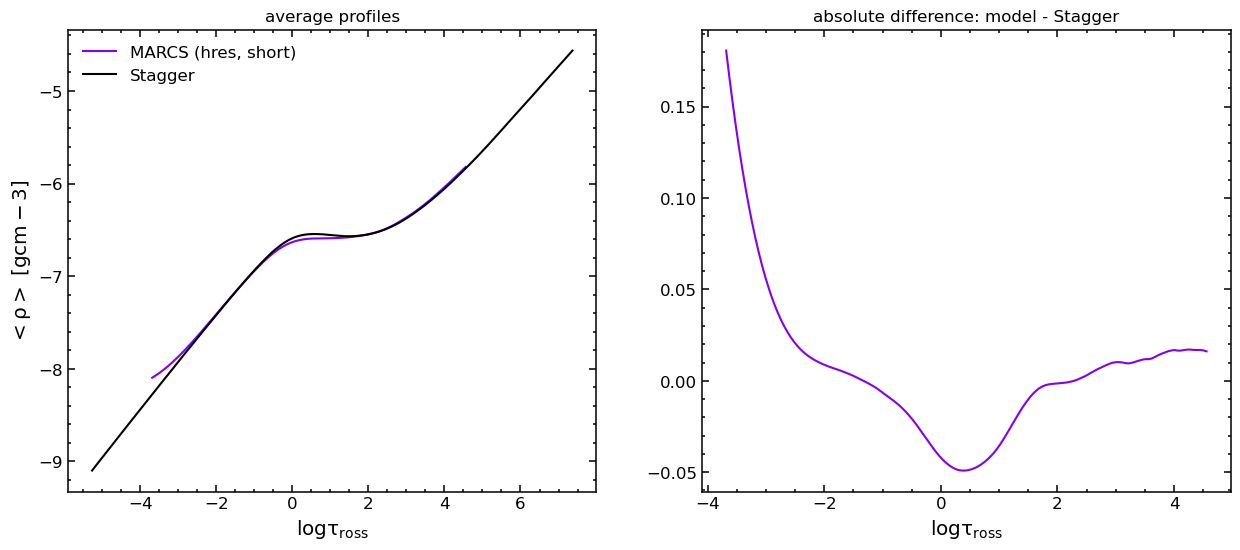

In [11]:
# Plotting
close()
f, ax = plt.subplots(1, 2, figsize=(15,6))
basic_plot!.(ax)


d_stagger  = log10.(MUST.plane_statistic(mean, stagger_t, :d))
z_stagger  = log10.(MUST.axis(stagger_t, :τ_ross, 3))

for i in eachindex(model)
    d = log10.(MUST.plane_statistic(mean, model_t[i], :d))
    z = log10.(MUST.axis(model_t[i], :τ_ross, 3))

    d_ip = Interpolations.linear_interpolation(reverse(z_stagger), reverse(d_stagger), extrapolation_bc = Line())(z)

    ax[1].plot(z, d, color=color[i], label=labels[i])
    ax[2].plot(z, d .- d_ip, color=color[i], label=labels[i])
end

## Stagger 
ax[1].plot(z_stagger,  d_stagger,  color="k", label="Stagger")

## Plot style
ax[1].set_ylabel(L"\rm <\rho> \ [g cm-3]", fontsize="x-large")
ax[1].set_xlabel(L"\rm \log \tau_{ross}", fontsize="x-large")
ax[2].set_xlabel(L"\rm \log \tau_{ross}", fontsize="x-large")

ax[1].set_title("average profiles", fontsize="large")
ax[2].set_title("absolute difference: model - Stagger", fontsize="large")

ax[1].legend(framealpha=0, loc="upper left", fontsize="large");

#ax[1].axhline(-6.545)
#ax[1].axhline(10300)
#ax[1].axvline(2)

#ax[1].set_ylim(-6.8, -6.4)
#ax[1].set_xlim(1.5, 2.5)


gcf()

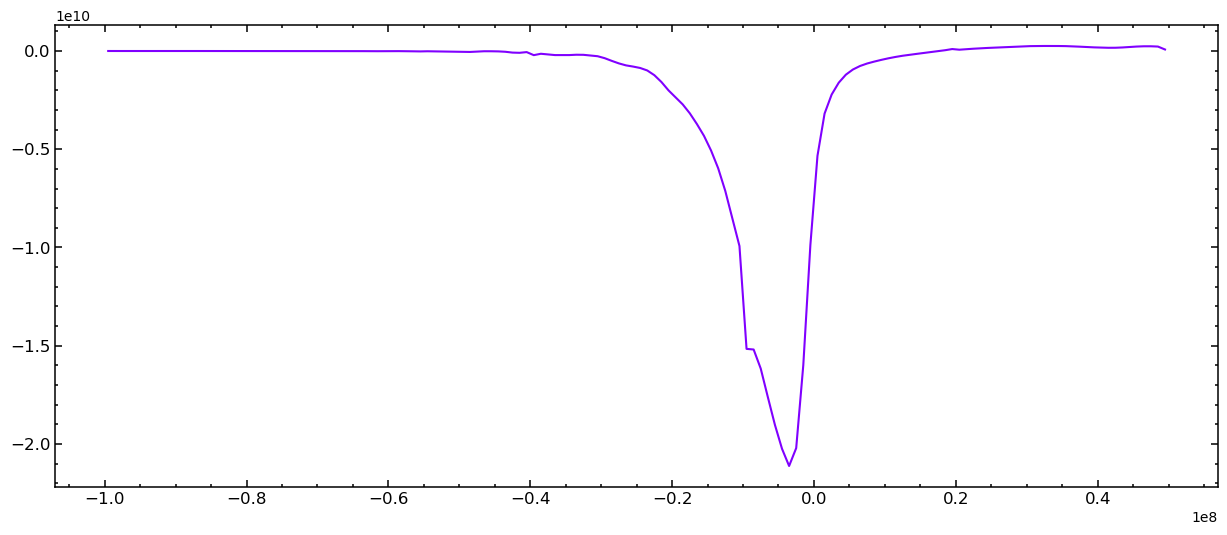

In [12]:
# Plotting
close()

f, ax = plt.subplots(1, 1, figsize=(15,6))
basic_plot!(ax)


#d_stagger  = log10.(MUST.plane_statistic(mean, stagger_t, :qr))
#z_stagger  = log10.(MUST.axis(stagger_t, :τ_ross, 3))

for i in eachindex(model)
    qrm = model[i][:qr] ./ model[i][:d]
    MUST.add!(model[i], qrm, :qrm)
    d = MUST.plane_statistic(mean, model[i], :qrm) 
    z = MUST.axis(model[i], :z)

    #d_ip = Interpolations.linear_interpolation(reverse(z_stagger), reverse(d_stagger), extrapolation_bc = Line())(z)

    ax.plot(z, d, color=color[i], label=labels[i])
    #ax[2].plot(z, d .- d_ip, color=color[i], label=labels[i])
end

## Stagger 
#ax[1].plot(z_stagger,  d_stagger,  color="k", label="Stagger")

## Plot style
#ax.set_ylabel(L"\rm <\Qr> \ [g cm-3]", fontsize="x-large")
#ax.set_xlabel(L"\rm \log \tau_{ross}", fontsize="x-large")
#ax.set_xlabel(L"\rm \log \tau_{ross}", fontsize="x-large")
#ax.set_title("average profiles", fontsize="large")
#ax.set_title("absolute difference: model - Stagger", fontsize="large")
#ax.legend(framealpha=0, loc="upper left", fontsize="large");

#ax[1].axhline(-6.545)
#ax[1].axhline(10300)
#ax[1].axvline(2)

#ax[1].set_ylim(-6.8, -6.4)
#ax[1].set_xlim(1.5, 2.5)


gcf()

# Average T-$\rho$ profiles

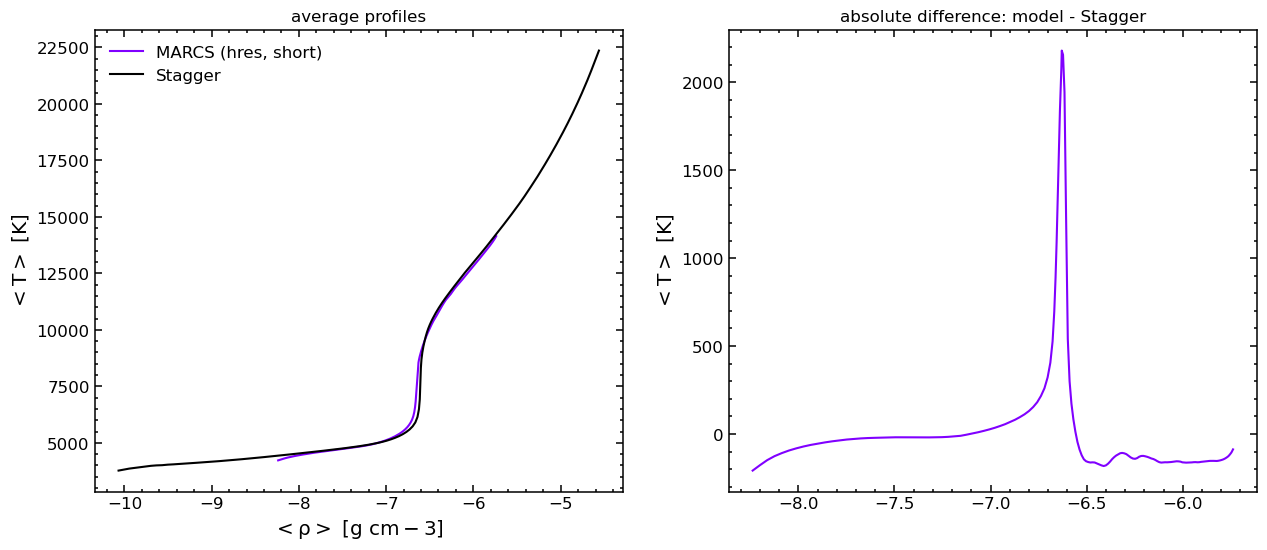

In [13]:
# Plotting
close()
f, ax = plt.subplots(1, 2, figsize=(15,6))
basic_plot!.(ax)


d_stagger  = MUST.plane_statistic(mean, stagger, :T)
z_stagger  = MUST.plane_statistic(mean, stagger, :d)


for i in eachindex(model)
    d = MUST.plane_statistic(mean, model[i], :T)
    z = MUST.plane_statistic(mean, model[i], :d)

    d_ip = Interpolations.linear_interpolation(reverse(z_stagger), reverse(d_stagger), extrapolation_bc = Line())(z)

    ax[1].plot(log10.(z), d, color=color[i], label=labels[i])
    ax[2].plot(log10.(z), d .- d_ip, color=color[i], label=labels[i])
end

## Stagger 
ax[1].plot(log10.(z_stagger), d_stagger, color="k", label="Stagger")

## Plot style
ax[1].set_xlabel(L"\rm <\rho> \ [g \ cm-3]", fontsize="x-large")
ax[1].set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")
ax[2].set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")

ax[1].set_title("average profiles", fontsize="large")
ax[2].set_title("absolute difference: model - Stagger", fontsize="large")

ax[1].legend(framealpha=0, loc="upper left", fontsize="large");

gcf()

# Velocity Fields

In [14]:
rms(x) = sqrt(mean(x .^2))

rms (generic function with 1 method)

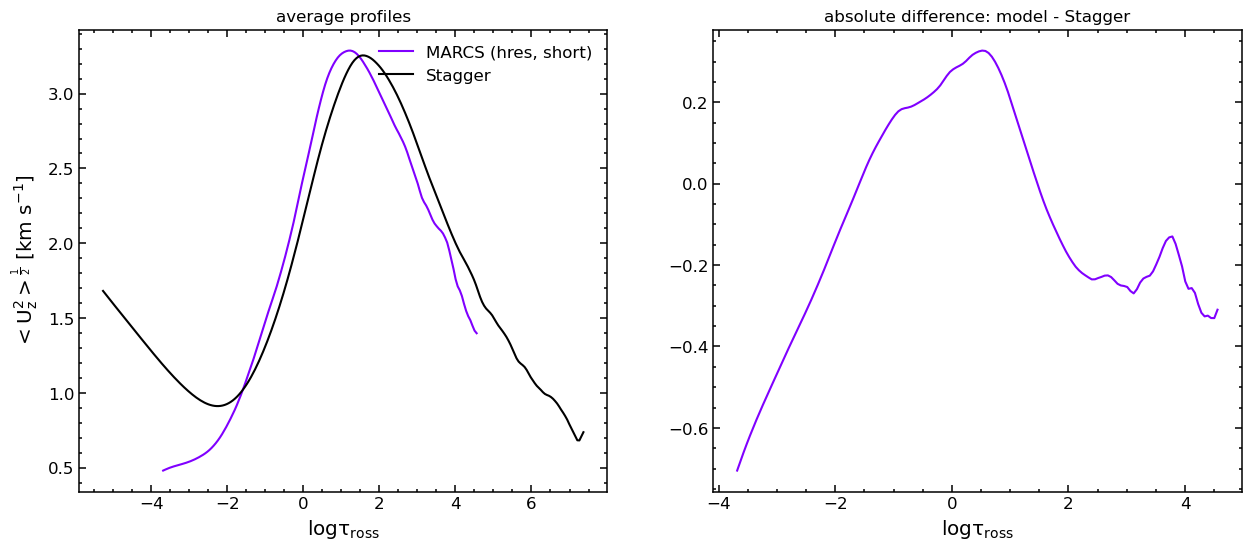

In [15]:
# Plotting
close()
f, ax = plt.subplots(1, 2, figsize=(15,6))
basic_plot!.(ax)


d_stagger  = MUST.plane_statistic(rms, stagger_t, :uz) ./ 1e5
z_stagger  = log10.(MUST.axis(stagger_t, :τ_ross, 3))

for i in eachindex(model)
    d = MUST.plane_statistic(rms, model_t[i], :uz) ./ 1e5
    z = log10.(MUST.axis(model_t[i], :τ_ross, 3))

    d_ip = Interpolations.linear_interpolation(reverse(z_stagger), reverse(d_stagger), extrapolation_bc = Line())(z)

    ax[1].plot(z, d, color=color[i], label=labels[i])
    ax[2].plot(z, d .- d_ip, color=color[i], label=labels[i])
end

## Stagger 
ax[1].plot(z_stagger,  d_stagger,  color="k", label="Stagger")

## Plot style
ax[1].set_ylabel(L"\rm <U_z^2>^{\frac{1}{2}} \ [km \ s^{-1}]", fontsize="x-large")
ax[1].set_xlabel(L"\rm \log \tau_{ross}", fontsize="x-large")
ax[2].set_xlabel(L"\rm \log \tau_{ross}", fontsize="x-large")

ax[1].set_title("average profiles", fontsize="large")
ax[2].set_title("absolute difference: model - Stagger", fontsize="large")

ax[1].legend(framealpha=0, loc="upper right", fontsize="large");

gcf()

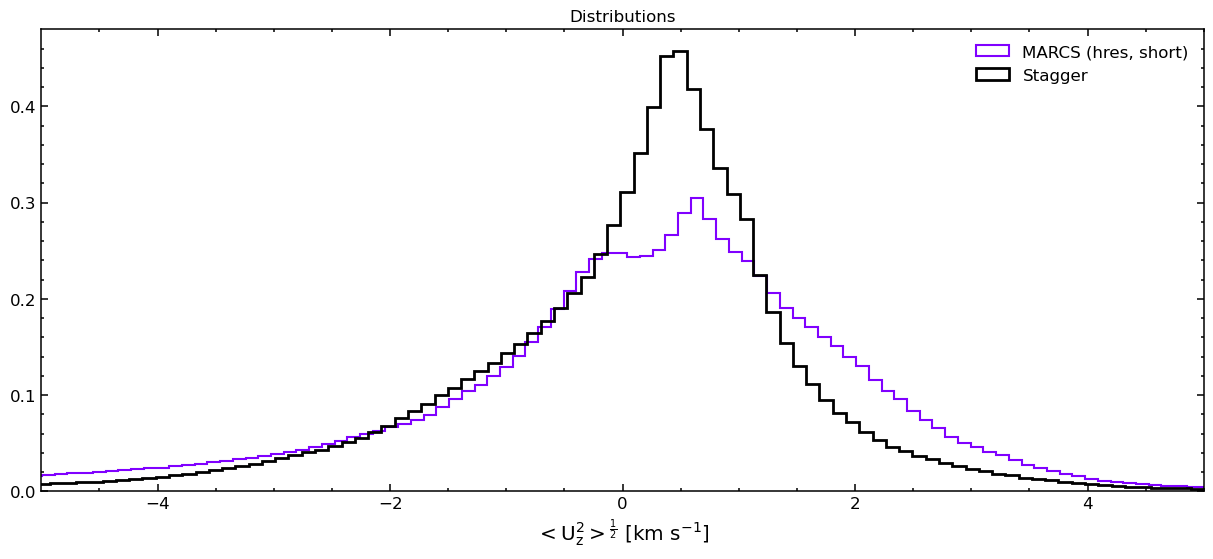

In [16]:
# Plotting
close()
f, ax = plt.subplots(1, 1, figsize=(15,6))
ax    = [ax]
basic_plot!.(ax)


d_stagger  = reshape(stagger[:uz], :) ./ 1e5

for i in eachindex(model)
    d = reshape(model[i][:uz], :) ./ 1e5

    ax[1].hist(d, color=color[i], label=labels[i], bins=200, histtype="step", lw=1.5, density=true)
end

## Stagger 
ax[1].hist(d_stagger,  color="k", label="Stagger", bins=200, histtype="step", lw=2., density=true)

## Plot style
ax[1].set_xlim(-5, 5)
ax[1].set_xlabel(L"\rm <U_z^2>^{\frac{1}{2}} \ [km \ s^{-1}]", fontsize="x-large")
ax[1].set_title("Distributions", fontsize="large")
ax[1].legend(framealpha=0, loc="upper right", fontsize="large");

gcf()

# Time evolution

In [17]:
function get_cmap(min_c, max_c, N; cmap="RdBu")
    cmap  = plt.get_cmap(cmap, N)    # 11 discrete colors
    cmap
end

get_cmap (generic function with 1 method)

In [18]:
#=b = [last(MUST.Boxes(folder_i)) for folder_i in folders]
min_snaps = argmin(length.(b))

var = :T
paths = []

for i in eachindex(b[min_snaps])
    ## Plotting
    close()
    f, ax = plt.subplots(1, 2, figsize=(15,6))
    basic_plot!.(ax)

    d_stagger  = MUST.plane_statistic(mean, stagger_t, var)
    z_stagger  = log10.(MUST.axis(stagger_t, :τ_ross, 3))

    ## Models
    for j in eachindex(b)
        d = MUST.plane_statistic(mean, b[j][i], var)
        z = log10.(MUST.axis(b[j][i], :τ_ross, 3))

        d_ip = Interpolations.linear_interpolation(reverse(z_stagger), reverse(d_stagger), extrapolation_bc = Line())(z)
        ax[1].plot(z, d, color=color[j], label=labels[j])
        ax[2].plot(z, d .- d_ip, color=color[j], label=labels[j])
    end

    ## Stagger
    ax[1].plot(z_stagger, d_stagger, color="k", label="Stagger")

    ## Setup
    ax[1].set_xlim(-6, 7.7)
    ax[1].set_ylim(3200,23000)
    ax[2].set_xlim(-6, 7.7)
    ax[2].set_ylim(-500,500)
    
    ax[1].set_title("snapshot $(i)", fontsize="x-large")
    ax[1].set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")
    ax[1].set_xlabel(L"\rm log \tau_{ross}", fontsize="x-large")
    ax[1].legend(framealpha=0, loc="upper left", fontsize="large");

    f.savefig("mtemp_$(i).png", bbox_inches="tight")
    append!(paths, ["mtemp_$(i).png"])

    plt.close()
end

gif_from_pngs(paths, "comp_$(var)_stagger.gif", duration=0.7);=#

In [19]:
#=b = [first(MUST.Boxes(folder_i)) for folder_i in folders]
min_snaps = argmin(length.(b))

paths = []
ix_plane = 100

#=var = :uz
lab = L"\rm vertical\ velocity\ [km \cdot s^{-1}]"
vmin = -4.
vmax = 4.
norm = 1e-5
make_log=false=#

#=var = :d
lab = L"\rm Density\ [g \cdot cm^{-3}]"
vmin = -8
vmax = -5.5
norm = 1
make_log=true=#

var = :T
lab = L"\rm temperature\ [K]"
vmin = 4500
vmax = 20000
norm = 1
make_log=false

for i in eachindex(b[min_snaps])
    ## Plotting
    close()
    f, ax = plt.subplots(1, length(b), figsize=(15,6))
    ax = if !(typeof(ax) <: AbstractArray)
        [ax]
    else
        ax
    end

    basic_plot!.(ax, label_fs="x-large")

    ## Models
    for j in eachindex(b)
        #tau_surface = MUST.reduce_by_column(optical_surface, b[j][i]);
        tau_surface = make_log ? log10.(b[j][i][var][ix_plane, :, :]') : b[j][i][var][ix_plane, :, :]'
        tau_surface .*= norm

        y = MUST.axis(b[j][i], :y) .*1e-5
        z = MUST.axis(b[j][i], :z) .*1e-5
        ymi,yma,zmi,zma = minimum(y), maximum(y), minimum(z), maximum(z)

        im = ax[j].imshow(tau_surface, vmin=vmin, vmax=vmax, cmap="hot", aspect="auto", extent=[ymi, yma, zma, zmi])

        cb = plt.colorbar(im, ax=ax)
        cb.set_label(lab, fontsize="xx-large")
        basic_plot!.(cb.ax, label_fs="x-large")

        ts = @sprintf("%i", b[j][i].parameter.time)
        ax[j].set_title("solar time: $(ts) min", fontsize="xx-large")
        ax[j].set_ylim(ax[j].get_ylim()[end:-1:1])
        #ax[j].set_ylim(-1.75e8*1e-5, 0.75e8*1e-5)
    end

    ## Setup
    ax[1].set_ylabel("z [km]", fontsize="xx-large")
    ax[1].set_xlabel("y [km]", fontsize="xx-large")

    f.savefig("mtemp_$(i).png", bbox_inches="tight")
    append!(paths, ["mtemp_$(i).png"])

    plt.close()
end

gif_from_pngs(paths, "x_slice_$(var).gif", duration=0.5);=#

In [20]:
#=b = [first(MUST.Boxes(folder_i)) for folder_i in folders]
min_snaps = argmin(length.(b))

paths = []
ix_plane = 100

var = :uz
lab = L"\rm vertical\ velocity\ [km \cdot s^{-1}]"
vmin = -4.
vmax = 4.
norm = 1e-5
make_log=false

#=var = :d
lab = L"\rm Density\ [g \cdot cm^{-3}]"
vmin = -8
vmax = -5.5
norm = 1
make_log=true

var = :T
lab = L"\rm temperature\ [K]"
vmin = 4500
vmax = 20000
norm = 1
make_log=false=#

for i in eachindex(b[min_snaps])
    ## Plotting
    close()
    f, ax = plt.subplots(1, length(b), figsize=(15,6))
    ax = if !(typeof(ax) <: AbstractArray)
        [ax]
    else
        ax
    end

    basic_plot!.(ax, label_fs="x-large")

    ## Models
    for j in eachindex(b)
        #tau_surface = MUST.reduce_by_column(optical_surface, b[j][i]);
        uy = b[j][i][:uy][ix_plane, :, :] .* norm
        uz = b[j][i][:uz][ix_plane, :, :] .* norm
    
        y = MUST.axis(b[j][i], :y) .*1e-5
        z = MUST.axis(b[j][i], :z) .*1e-5

        yy, zz = MUST.meshgrid(y, z)

        ymi,yma,zmi,zma = minimum(y), maximum(y), minimum(z), maximum(z)

        im = ax[j].quiver(yy, zz, uy, uz, color="k", scale_units="xy")

        ts = @sprintf("%i", b[j][i].parameter.time)
        ax[j].set_title("solar time: $(ts) min", fontsize="xx-large")
        #ax[j].set_ylim(ax[j].get_ylim()[end:-1:1])
        ax[j].set_ylim(-1.75e8*1e-5, 0.75e8*1e-5)
    end

    ## Setup
    ax[1].set_ylabel("z [km]", fontsize="xx-large")
    ax[1].set_xlabel("y [km]", fontsize="xx-large")

    f.savefig("mtemp_$(i).png", bbox_inches="tight")
    append!(paths, ["mtemp_$(i).png"])

    plt.close()

end

gif_from_pngs(paths, "x_slice_vec_$(var).gif", duration=0.5);=#

In [21]:
#=b = [last(MUST.Boxes(folder_i)) for folder_i in folders]
min_snaps = argmin(length.(b))

paths = []

optical_surface = MUST.height_where(; τ_ross=1.0)
tau_surface_stagger = MUST.reduce_by_value(mean, stagger_t, τ_ross=1.0)

for i in eachindex(b[min_snaps])
    ## Plotting
    close()
    f, ax = plt.subplots(1, length(b)+1, figsize=(15,6))
    basic_plot!.(ax)

    ## Models
    for j in eachindex(b)
        #tau_surface = MUST.reduce_by_column(optical_surface, b[j][i]);
        tau_surface = MUST.reduce_by_value(mean, b[j][i], τ_ross=1.0)

        ax[j].imshow(MUST.axis(tau_surface, :uz) ./1e5)

        ax[j].set_title(labels[j])
    end

    ## Stagger
    #tau_surface_stagger = MUST.reduce_by_column(optical_surface, stagger);
    ax[end].imshow(MUST.axis(tau_surface_stagger, :uz) ./1e5)

    ## Setup
    ax[1].set_ylabel("snapshot $(i)")
    f.savefig("mtemp_$(i).png", bbox_inches="tight")
    append!(paths, ["mtemp_$(i).png"])

    plt.close()
end

gif_from_pngs(paths, "comp_plane_stagger.gif", duration=0.7);=#

In [22]:
for i in eachindex(folders)
    @info "Model Information - Model $(labels[i]): \n      Teff = $(model[i].parameter.teff) K"
end

┌ Info: Model Information - Model MARCS (hres, short): 
│       Teff = 5590.786731264232 K
└ @ Main /u/peitner/DISPATCH/MUST.jl/examples/solar_model/profiles_comparison.ipynb:2
